# Test for different solvers for stochastic equation

Based on development-smesolver-new-methods by Manuel Grimm, Niels Lörch, and Denis V. Vasilyev.

Eric Giguere, March 2018

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

from qutip import *
from qutip.ui.progressbar import BaseProgressBar
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
y_sse = None
import time

## Just check that analytical solution coincides with the solution of ODE for the variance

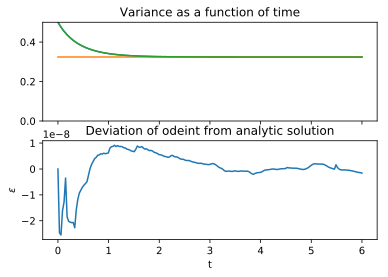

In [2]:
def arccoth(x):
    return 0.5*np.log((1.+x)/(x-1.))

############ parameters #############

th = 0.1 # Interaction parameter
alpha = np.cos(th)
beta = np.sin(th)
gamma = 1.
def gammaf(t):
    return 0.25+t/12+t*t/6

def f_gamma(t,*args):
    return (0.25+t/12+t*t/6)**(0.5)

################# Solution of the differential equation for the variance Vc ####################
T = 6.
N_store = 200
tlist = np.linspace(0,T,N_store)
y0 = 0.5
def func(y, t):
    return -(gammaf(t) - alpha*beta)*y - 2*alpha*alpha*y*y + 0.5*gammaf(t)
y_td = odeint(func, y0, tlist)

def func(y, t):
    return -(gamma - alpha*beta)*y - 2*alpha*alpha*y*y + 0.5*gamma
y = odeint(func, y0, tlist)

############ Exact steady state solution for Vc #########################
Vc = (alpha*beta - gamma + np.sqrt((gamma-alpha*beta)**2 + 4*gamma*alpha**2))/(4*alpha**2)

#### Analytic solution
A = (gamma**2 + alpha**2 * (beta**2 + 4*gamma) - 2*alpha*beta*gamma)**0.5
B = arccoth((-4*alpha**2*y0 + alpha*beta - gamma)/A)
y_an = (alpha*beta - gamma + A / np.tanh(0.5*A*tlist - B))/(4*alpha**2)

f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

ax.set_title('Variance as a function of time')
ax.plot(tlist,y)
ax.plot(tlist,Vc*np.ones_like(tlist))
ax.plot(tlist,y_an)
ax.set_ylim(0,0.5)

ax2.set_title('Deviation of odeint from analytic solution')
ax2.set_xlabel('t')
ax2.set_ylabel(r'$\epsilon$')
ax2.plot(tlist,y_an - y.T[0]);

## Test of different SME solvers

In [3]:
####################### Model ###########################

N = 30                   # number of Fock states
Id = qeye(N)
a = destroy(N)
s = 0.5*((alpha+beta)*a + (alpha-beta)*a.dag())
x = (a + a.dag())/np.sqrt(2)
H = Id
c_op = [np.sqrt(gamma)*a]
c_op_td = [[a,f_gamma]]
sc_op = [s]
e_op = [x, x*x]
rho0 = fock_dm(N,0)       # initial vacuum state
#sc_len=1                 # one stochastic operator


############## time steps and trajectories ###################

ntraj = 1 #100           # number of trajectories
T = 6.                   # final time          
N_store = 200            # number of time steps for which we save the expectation values/density matrix
tlist = np.linspace(0,T,N_store)
ddt = (tlist[1]-tlist[0])

Nsubs = list((13*np.logspace(0,1,10)).astype(np.int))
stepsizes = [ddt/j for j in Nsubs] # step size is doubled after each evaluation 
Nt = len(Nsubs)                    # number of step sizes that we compare
Nsubmax = Nsubs[-1]                # Number of intervals for the smallest step size; 
dtmin = (tlist[1]-tlist[0])/(Nsubmax)


## Plotting the figure - Constant case

In [4]:
# Analetical solution not available: 
# Compute the evolution with the best solver and very small step size and use it as the reference
sol = ssesolve(H, fock(N), tlist, [sc_op[0]+c_op[0]], e_op, nsubsteps=2000, method="homodyne",solver="taylor2.0")
y_sse = sol.expect[1]-sol.expect[0]*sol.expect[0].conj()

Total run time: 164.50s


In [5]:
ntraj = 1
def run_sse(**kwargs):
    epsilon = np.zeros(Nt)
    std = np.zeros(Nt)
    print(kwargs)
    for jj in range(0,Nt):
        for j in range(0,ntraj):
            Nsub = Nsubs[jj]#int(Nsubmax/(2**jj))
            sol = ssesolve(H, fock(N), tlist, [sc_op[0]+c_op[0]], e_op, nsubsteps=Nsub, **kwargs)
            epsilon_j = 1/T * np.sum(np.abs(y_sse - (sol.expect[1]-sol.expect[0]*sol.expect[0].conj())))*ddt
            epsilon[jj] += epsilon_j
            std[jj] += epsilon_j
    epsilon/= ntraj
    std = np.sqrt(1/ntraj * (1/ntraj * std - epsilon**2))
    return epsilon

def get_stats(**kw):
    start = time.time()
    y = run_sse(**kw)
    tag = str(kw["solver"])
    x = np.log(stepsizes)
    ly = np.log(y)
    fit = np.polyfit(x, ly, 1)[0]
    return y,tag,fit,time.time()-start

stats_cte = []
stats_cte.append(get_stats(solver='euler-maruyama'))

stats_cte.append(get_stats(solver='platen'))
stats_cte.append(get_stats(solver='pred-corr'))
stats_cte.append(get_stats(solver='milstein'))
stats_cte.append(get_stats(solver='milstein-imp', tol=1e-9))
stats_cte.append(get_stats(solver='pred-corr-2'))

stats_cte.append(get_stats(solver='explicit1.5'))
stats_cte.append(get_stats(solver="taylor1.5"))
stats_cte.append(get_stats(solver="taylor1.5-imp", tol=1e-9))

stats_cte.append(get_stats(solver="taylor2.0"))
stats_cte.append(get_stats(solver="taylor2.0", noiseDepth=500))

{'solver': 'euler-maruyama'}
Total run time:   0.14s
Total run time:   0.15s
Total run time:   0.18s
Total run time:   0.23s
Total run time:   0.30s
Total run time:   0.38s
Total run time:   0.49s
Total run time:   0.64s
Total run time:   0.81s
Total run time:   1.04s
{'solver': 'platen'}
Total run time:   0.44s
Total run time:   0.50s
Total run time:   0.63s
Total run time:   0.82s
Total run time:   1.06s
Total run time:   1.34s
Total run time:   1.75s
Total run time:   2.33s
Total run time:   3.06s
Total run time:   3.86s
{'solver': 'pred-corr'}
Total run time:   0.26s
Total run time:   0.31s
Total run time:   0.41s
Total run time:   0.57s
Total run time:   0.82s
Total run time:   0.90s
Total run time:   1.16s
Total run time:   1.49s
Total run time:   1.95s
Total run time:   2.48s
{'solver': 'milstein'}
Total run time:   0.14s
Total run time:   0.18s
Total run time:   0.22s
Total run time:   0.29s
Total run time:   0.37s
Total run time:   0.47s
Total run time:   0.63s
Total run time:

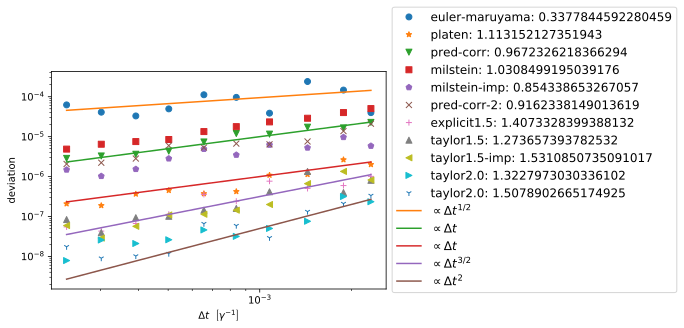

In [6]:
fig = plt.figure()
ax = plt.subplot(111)
mark = "o*vspx+^<>1hdD"

for i,run in enumerate(stats_cte):
    ax.loglog(stepsizes, run[0], mark[i], label=run[1]+": " + str(run[2]))

ax.loglog(stepsizes, 0.003*np.array(stepsizes)**0.5, label="$\propto\Delta t^{1/2}$")
ax.loglog(stepsizes, 0.01*np.array(stepsizes)**1, label="$\propto\Delta t$")
ax.loglog(stepsizes, 0.001*np.array(stepsizes)**1, label="$\propto\Delta t$")
ax.loglog(stepsizes, 0.01*np.array(stepsizes)**1.5, label="$\propto\Delta t^{3/2}$")
ax.loglog(stepsizes, 0.05*np.array(stepsizes)**2.0, label="$\propto\Delta t^{2}$")

ax.set_xlabel(r'$\Delta t$  $\left[\gamma^{-1}\right]$')
ax.set_ylabel('deviation')

lgd=ax.legend(loc='center left', bbox_to_anchor=(1, 0.64), prop={'size':12})


## Deterministic part time dependent

Total run time: 258.38s


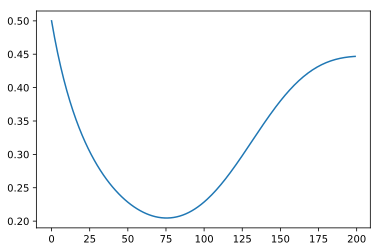

In [7]:
def H_f(t,args):
    return 0.125+t/12+t*t/72
sol = ssesolve([H,[c_op[0].dag()*c_op[0]/2,H_f]], fock(N), tlist, sc_op, e_op, 
                       nsubsteps=2500, method="homodyne",solver="taylor2.0")
y_sse_td = sol.expect[1]-sol.expect[0]*sol.expect[0].conj()
plt.plot(y_sse_td)

In [8]:
ntraj = 1
def run_sse_td(**kwargs):
    epsilon = np.zeros(Nt)
    std = np.zeros(Nt)
    print(kwargs)
    for jj in range(0,Nt):
        for j in range(0,ntraj):
            Nsub = Nsubs[jj]#int(Nsubmax/(2**jj))
            sol = ssesolve([H,[c_op[0].dag()*c_op[0]/2,H_f]], fock(N), tlist, sc_op, e_op, nsubsteps=Nsub, **kwargs)
            epsilon_j = 1/T * np.sum(np.abs(y_sse_td - (sol.expect[1]-sol.expect[0]*sol.expect[0].conj())))*ddt
            epsilon[jj] += epsilon_j
            std[jj] += epsilon_j
    epsilon/= ntraj
    std = np.sqrt(1/ntraj * (1/ntraj * std - epsilon**2))
    return epsilon

def get_stats(**kw):
    y = run_sse_td(**kw)
    tag = str(kw["solver"])
    x = np.log(stepsizes)
    ly = np.log(y)
    fit = np.polyfit(x, ly, 1)[0]
    return y,tag,fit


stats_td = []
stats_td.append(get_stats(solver='euler-maruyama'))

stats_td.append(get_stats(solver='platen'))
stats_td.append(get_stats(solver='pred-corr'))
stats_td.append(get_stats(solver='milstein'))
stats_td.append(get_stats(solver='milstein-imp'))
stats_td.append(get_stats(solver='pred-corr-2'))

stats_td.append(get_stats(solver='explicit1.5'))
stats_td.append(get_stats(solver="taylor1.5"))
stats_td.append(get_stats(solver="taylor1.5-imp", tol=1e-9))

stats_td.append(get_stats(solver="taylor2.0"))
stats_td.append(get_stats(solver="taylor2.0", noiseDepth=500))

{'solver': 'euler-maruyama'}
Total run time:   0.18s
Total run time:   0.16s
Total run time:   0.16s
Total run time:   0.28s
Total run time:   0.34s
Total run time:   0.44s
Total run time:   0.55s
Total run time:   0.70s
Total run time:   0.90s
Total run time:   1.17s
{'solver': 'platen'}
Total run time:   0.43s
Total run time:   0.51s
Total run time:   0.67s
Total run time:   0.89s
Total run time:   1.11s
Total run time:   1.42s
Total run time:   1.86s
Total run time:   2.34s
Total run time:   3.09s
Total run time:   4.04s
{'solver': 'pred-corr'}
Total run time:   0.26s
Total run time:   0.32s
Total run time:   0.41s
Total run time:   0.54s
Total run time:   0.69s
Total run time:   0.89s
Total run time:   1.12s
Total run time:   1.45s
Total run time:   1.90s
Total run time:   2.51s
{'solver': 'milstein'}
Total run time:   0.19s
Total run time:   0.22s
Total run time:   0.31s
Total run time:   0.33s
Total run time:   0.42s
Total run time:   0.65s
Total run time:   0.96s
Total run time:

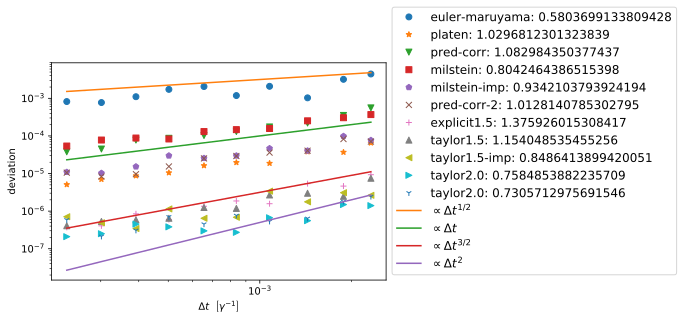

In [9]:
fig = plt.figure()
ax = plt.subplot(111)

mark = "o*vspx+^<>1hdD"

for i,run in enumerate(stats_td):
    ax.loglog(stepsizes, run[0], mark[i], label=run[1]+": " + str(run[2]))
    
ax.loglog(stepsizes, 0.1*np.array(stepsizes)**0.5, label="$\propto\Delta t^{1/2}$")
ax.loglog(stepsizes, 0.1*np.array(stepsizes)**1, label="$\propto\Delta t$")
ax.loglog(stepsizes, 0.1*np.array(stepsizes)**1.5, label="$\propto\Delta t^{3/2}$")
ax.loglog(stepsizes, 0.5*np.array(stepsizes)**2.0, label="$\propto\Delta t^{2}$")

ax.set_xlabel(r'$\Delta t$  $\left[\gamma^{-1}\right]$')
ax.set_ylabel('deviation')

lgd=ax.legend(loc='center left', bbox_to_anchor=(1, 0.64), prop={'size':12})

## Both d1 and d2 time-dependent

Total run time:  76.28s


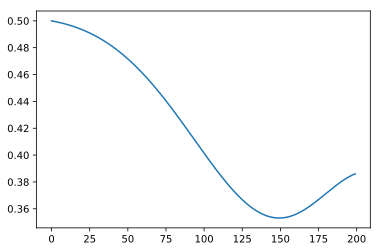

In [17]:
def H_f(t,args):
    return 0.125+t/12+t*t/72
def H_bf(t,args):
    return 0.125+t/10+t*t/108
sc_op_td = [[sc_op[0],H_bf]]
sol = ssesolve([H,[c_op[0].dag()*c_op[0]/2,H_f]], fock(N), tlist, sc_op_td, e_op, 
                       nsubsteps=2000, method="homodyne",solver="taylor15")
y_sse_btd = sol.expect[1]-sol.expect[0]*sol.expect[0].conj()
plt.plot(y_sse_btd)

In [18]:
ntraj = 1
def run_sse_td(**kwargs):
    epsilon = np.zeros(Nt)
    std = np.zeros(Nt)
    print(kwargs)
    for jj in range(0,Nt):
        for j in range(0,ntraj):
            Nsub = Nsubs[jj]#int(Nsubmax/(2**jj))
            sol = ssesolve([H,[c_op[0].dag()*c_op[0]/2,H_f]], fock(N), tlist, sc_op_td, e_op, nsubsteps=Nsub, **kwargs)
            epsilon_j = 1/T * np.sum(np.abs(y_sse_btd - (sol.expect[1]-sol.expect[0]*sol.expect[0].conj())))*ddt
            epsilon[jj] += epsilon_j
            std[jj] += epsilon_j
    epsilon/= ntraj
    std = np.sqrt(1/ntraj * (1/ntraj * std - epsilon**2))
    return epsilon

def get_stats_b(**kw):
    y = run_sse_td(**kw)
    tag = str(kw["solver"])
    x = np.log(stepsizes)
    ly = np.log(y)
    fit = np.polyfit(x, ly, 1)[0]
    return y,tag,fit


stats_d2_td = []
stats_d2_td.append(get_stats_b(solver='euler-maruyama'))

stats_d2_td.append(get_stats_b(solver='platen'))
stats_d2_td.append(get_stats_b(solver='pred-corr'))
stats_d2_td.append(get_stats_b(solver='milstein'))
stats_d2_td.append(get_stats_b(solver='milstein-imp'))
stats_d2_td.append(get_stats_b(solver='pred-corr-2'))

stats_d2_td.append(get_stats_b(solver='explicit1.5'))
stats_d2_td.append(get_stats_b(solver="taylor1.5"))
stats_d2_td.append(get_stats_b(solver="taylor1.5-imp", tol=1e-9))

{'solver': 'euler-maruyama'}
Total run time:   0.25s
Total run time:   0.15s
Total run time:   0.28s
Total run time:   0.24s
Total run time:   0.33s
Total run time:   0.41s
Total run time:   0.52s
Total run time:   0.71s
Total run time:   0.85s
Total run time:   1.05s
{'solver': 'platen'}
Total run time:   0.34s
Total run time:   0.41s
Total run time:   0.56s
Total run time:   1.14s
Total run time:   0.90s
Total run time:   1.15s
Total run time:   1.47s
Total run time:   1.89s
Total run time:   2.41s
Total run time:   3.17s
{'solver': 'pred-corr'}
Total run time:   0.17s
Total run time:   0.24s
Total run time:   0.29s
Total run time:   0.35s
Total run time:   0.46s
Total run time:   0.58s
Total run time:   0.74s
Total run time:   0.99s
Total run time:   1.27s
Total run time:   1.69s
{'solver': 'milstein'}
Total run time:   0.11s
Total run time:   0.16s
Total run time:   0.16s
Total run time:   0.21s
Total run time:   0.27s
Total run time:   0.34s
Total run time:   0.44s
Total run time:

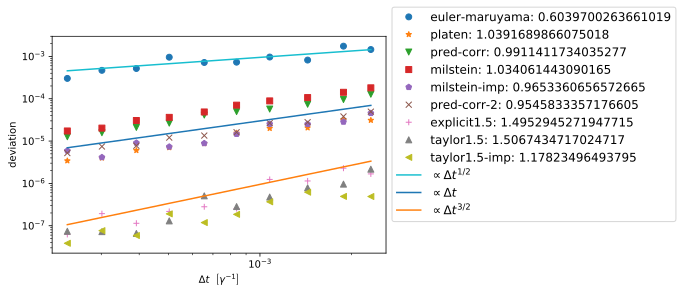

In [19]:
fig = plt.figure()
ax = plt.subplot(111)
mark = "o*vspx+^<>1hdD"

for i,run in enumerate(stats_d2_td):
    ax.loglog(stepsizes, run[0], mark[i], label=run[1]+": " + str(run[2]))

ax.loglog(stepsizes, 0.03*np.array(stepsizes)**0.5, label="$\propto\Delta t^{1/2}$")
ax.loglog(stepsizes, 0.03*np.array(stepsizes)**1, label="$\propto\Delta t$")
ax.loglog(stepsizes, 0.03*np.array(stepsizes)**1.5, label="$\propto\Delta t^{3/2}$")

ax.set_xlabel(r'$\Delta t$  $\left[\gamma^{-1}\right]$')
ax.set_ylabel('deviation')

lgd=ax.legend(loc='center left', bbox_to_anchor=(1, 0.64), prop={'size':12})

## Multiple sc_ops, time-dependent

Total run time: 343.58s


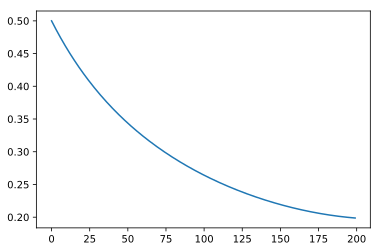

In [13]:
def H_f(t,args):
    return 0.125+t/12+t*t/36
def H_bf(t,args):
    return 0.125+t/10+t*t/108
sc_op_td = [[sc_op[0]],[sc_op[0],H_bf],[sc_op[0],H_f]]

sol = ssesolve([H,[c_op[0].dag()*c_op[0]/2,H_f]], fock(N), tlist/3, sc_op_td, e_op, 
                       nsubsteps=2000, method="homodyne",solver="taylor15")
y_sse_multi = sol.expect[1]-sol.expect[0]*sol.expect[0].conj()
plt.plot(y_sse_multi)

In [14]:
ntraj = 1
def run_sss_multi(**kwargs):
    epsilon = np.zeros(Nt)
    std = np.zeros(Nt)
    print(kwargs)
    for jj in range(0,Nt):
        for j in range(0,ntraj):
            Nsub = Nsubs[jj]#int(Nsubmax/(2**jj))
            sol = ssesolve([H,[c_op[0].dag()*c_op[0]/2,H_f]], fock(N), tlist/3, sc_op_td, e_op, nsubsteps=Nsub, **kwargs)
            epsilon_j = 1/T * np.sum(np.abs(y_sse_multi - (sol.expect[1]-sol.expect[0]*sol.expect[0].conj())))*ddt
            epsilon[jj] += epsilon_j
            std[jj] += epsilon_j
    epsilon/= ntraj
    std = np.sqrt(1/ntraj * (1/ntraj * std - epsilon**2))
    
    return epsilon

def get_stats_multi(**kw):
    y = run_sss_multi(**kw)
    tag = str(kw["solver"])
    x = np.log(stepsizes)
    ly = np.log(y)
    fit = np.polyfit(x, ly, 1)[0]
    return (y,tag,fit)


stats_multi = []
stats_multi.append(get_stats_multi(solver='euler-maruyama'))

stats_multi.append(get_stats_multi(solver="platen"))
stats_multi.append(get_stats_multi(solver='pred-corr'))
stats_multi.append(get_stats_multi(solver='milstein'))
stats_multi.append(get_stats_multi(solver='milstein-imp'))
stats_multi.append(get_stats_multi(solver='pred-corr-2'))

stats_multi.append(get_stats_multi(solver='explicit1.5'))
stats_multi.append(get_stats_multi(solver="taylor1.5"))
stats_multi.append(get_stats_multi(solver="taylor1.5-imp", tol=1e-9))

{'solver': 'euler-maruyama'}
Total run time:   0.41s
Total run time:   0.56s
Total run time:   0.40s
Total run time:   0.75s
Total run time:   0.70s
Total run time:   0.90s
Total run time:   1.62s
Total run time:   2.15s
Total run time:   3.35s
Total run time:   3.28s
{'solver': 'platen'}
Total run time:   1.52s
Total run time:   2.28s
Total run time:   2.07s
Total run time:   3.27s
Total run time:   3.71s
Total run time:   4.70s
Total run time:   7.20s
Total run time:   9.65s
Total run time:  11.76s
Total run time:  14.92s
{'solver': 'pred-corr'}
Total run time:   0.57s
Total run time:   0.70s
Total run time:   1.18s
Total run time:   1.33s
Total run time:   2.01s
Total run time:   2.24s
Total run time:   2.71s
Total run time:   4.29s
Total run time:   5.56s
Total run time:   6.50s
{'solver': 'milstein'}
Total run time:   0.44s
Total run time:   0.51s
Total run time:   0.66s
Total run time:   1.06s
Total run time:   1.28s
Total run time:   1.54s
Total run time:   1.91s
Total run time:

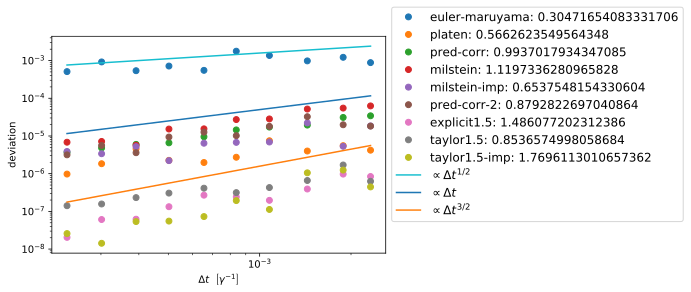

In [15]:
fig = plt.figure()
ax = plt.subplot(111)
mark = "o*vspx+^<>Dd"

for run in stats_multi:
    ax.loglog(stepsizes, run[0], 'o', label=run[1]+": " + str(run[2]))

ax.loglog(stepsizes, 0.05*np.array(stepsizes)**0.5, label="$\propto\Delta t^{1/2}$")
ax.loglog(stepsizes, 0.05*np.array(stepsizes)**1, label="$\propto\Delta t$")
ax.loglog(stepsizes, 0.05*np.array(stepsizes)**1.5, label="$\propto\Delta t^{3/2}$")

ax.set_xlabel(r'$\Delta t$  $\left[\gamma^{-1}\right]$')
ax.set_ylabel('deviation')

lgd=ax.legend(loc='center left', bbox_to_anchor=(1, 0.64), prop={'size':12})

## Versions

In [16]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.4.0.dev0+1cf1dd3e
Numpy,1.16.0
SciPy,1.2.0
matplotlib,3.0.2
Cython,0.29.2
Number of CPUs,2
BLAS Info,OPENBLAS
IPython,7.2.0
Python,"3.6.7 (default, Oct 22 2018, 11:32:17) [GCC 8.2.0]"
OS,posix [linux]
